In [4]:
import numpy as np
import matplotlib.pyplot as plt
import HW3_utils_data as utils
from scipy.special import legendre
from scipy.integrate import simpson
from scipy.stats import norm

In [6]:

P = 20

basis = [legendre(n) for n in range(P)]  # Basis functions


# Monte Carlo Simulation

Sample-0, Alpha--0.1280
Sample-1, Alpha--0.9481
Sample-2, Alpha-0.0993
Sample-3, Alpha--0.1294
Sample-4, Alpha--0.1593
Sample-5, Alpha--0.3393
Sample-6, Alpha--0.5907
Sample-7, Alpha-0.2385
Sample-8, Alpha--0.4007
Sample-9, Alpha--0.4663
Sample-10, Alpha-0.2423
Sample-11, Alpha-0.0583
Sample-12, Alpha--0.7308
Sample-13, Alpha-0.0272
Sample-14, Alpha--0.6311
Sample-15, Alpha-0.5707
Sample-16, Alpha-0.7080
Sample-17, Alpha--0.0115
Sample-18, Alpha-0.6931
Sample-19, Alpha--0.8407
Sample-20, Alpha-0.0105
Sample-21, Alpha--0.8694
Sample-22, Alpha--0.1438
Sample-23, Alpha--0.8069
Sample-24, Alpha--0.7457
Sample-25, Alpha-0.1935
Sample-26, Alpha--0.5480
Sample-27, Alpha--0.7861
Sample-28, Alpha--0.5594
Sample-29, Alpha--0.3003
Sample-30, Alpha--0.0644
Sample-31, Alpha--0.5965
Sample-32, Alpha-0.2808
Sample-33, Alpha--0.0339
Sample-34, Alpha-0.0105
Sample-35, Alpha--0.2262
Sample-36, Alpha-0.5873
Sample-37, Alpha-0.1600
Sample-38, Alpha--0.6754
Sample-39, Alpha-0.4015
Sample-40, Alpha-0.9291
S

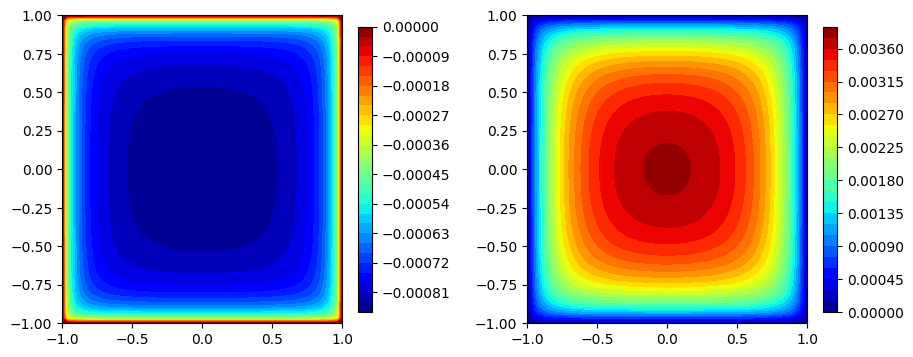

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2)

def gauss_seidel(alpha, u, b, dx, dy):
    nx, ny = [*u.shape]
    u_plus_1 = u.copy()
    # apply evolution operator
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            u_plus_1[i, j] = (0.25 * (alpha * (u_plus_1[i-1, j] + u[i+1, j] + u_plus_1[i, j-1]
                                               + u[i, j+1]) - b[i, j]*(dx*dy)))    
    return u_plus_1

def jacobi(alpha, u, b, dx, dy):
    u_plus_1 = np.zeros(u.shape)
    # apply evolution operator
    u_plus_1[1:-1, 1:-1] = (0.25 * (alpha * (u[:-2, 1:-1] + u[2:, 1:-1] + u[1:-1, :-2]
                                             + u[1:-1, 2:]) - b[1:-1, 1:-1]*(dx*dy))) 
    # copy boundary conditions
    u_plus_1[0,:]  = u[0,:]
    u_plus_1[-1,:] = u[-1,:]
    u_plus_1[:,0]  = u[:,0]
    u_plus_1[:,-1] = u[:,-1]
    return u_plus_1

nx = 64                            # number of points in the x direction
ny = 64                            # number of points in the y direction
xmin, xmax = -1, 1                  # limits in the x direction
ymin, ymax = -1, 1                  # limits in the y direction
dx = (xmax - xmin) / (nx-1)         # grid spacing in the x direction
dy = (ymax - ymin) / (ny-1)         # grid spacing in the y direction

# Create the gridline locations and the mesh grid;
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Compute the rhs
b = np.ones((nx, ny))
b[0, :] = b[-1, :] = b[:, 0] = b[:, -1] = 0     # Boundary conditions

u0 = np.zeros((nx, ny))
u_plus_1 = u0 

mcs = 2000
max_it = 10000
sol = []
for samples in range(mcs):
    alpha = np.random.uniform(-1,1)
    print('Sample-{}, Alpha-{:0.4f}'.format(samples, alpha))
    
    for it in range(max_it):
        u = u_plus_1.copy()
        u_plus_1 = jacobi(alpha, u, b, dx=dx, dy=dy)
    sol.append(u_plus_1)

sol = np.stack(sol)
mean = np.nanmean(sol, axis=0)
std = np.nanstd(sol, axis=0)

# %%
fig1 = plt.figure(figsize=(10,4), dpi=100)
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.contourf(X, Y, mean, cmap='jet', levels=32)
plt.colorbar(fraction=0.046)

plt.subplot(1,2,2)
plt.contourf(X, Y, std, cmap='jet', levels=32)
plt.colorbar(fraction=0.046)
plt.show()

In [9]:
sol[50,5,10]

-0.00027639001974639105

# Non Intrusive PCE

In [11]:
np.random.seed(42)

num_samples = 2000
samples = np.random.uniform(-1,1,num_samples)

PHI = np.zeros((num_samples, P))
for i in range(P):
    PHI[:, i] = basis[i](samples)
    
PHI

array([[ 1.        , -0.25091976, -0.40555891, ...,  0.18668886,
         0.00348345, -0.17856526],
       [ 1.        ,  0.90142861,  0.71886032, ...,  0.21146059,
         0.10190182, -0.02145124],
       [ 1.        ,  0.46398788, -0.17707287, ...,  0.16796585,
         0.17338345, -0.00246399],
       ...,
       [ 1.        , -0.86208397,  0.61478315, ...,  0.16171019,
        -0.24083219,  0.25110878],
       [ 1.        , -0.88589056,  0.67720312, ..., -0.05863879,
        -0.07309767,  0.18165736],
       [ 1.        , -0.43562585, -0.21534518, ..., -0.20084345,
         0.09162749,  0.11254294]])

In [12]:
Uxy = np.zeros((P, nx, ny))

for i in range(nx):
    for j in range(ny):
        
        y = sol[:,i,j]
        
        Uxy[:,i,j] = np.linalg.inv(PHI.T@PHI)@(PHI.T@y)

In [14]:
w = np.linspace(-1,1,2000)

u_xtw = np.zeros((nx, ny, w.shape[0]))
for i in range(len(w)):
    for k in range(P):
        u_xtw[:, :, i] += Uxy[k, :, :]*basis[k](w[i])

In [20]:
mean = np.zeros((nx, ny))

for i in range(nx):
    for j in range(ny):
        mean[i, j] = simpson(u_xtw[i,j,:]*0.5, w)

In [23]:
var = np.zeros((nx, ny))

integrand = np.zeros((nx, ny, len(w)))
for k in range(len(w)):
    integrand[:,:,k] = (u_xtw[:,:,k] - mean)**2

In [26]:
for i in range(nx):
    for j in range(ny):
        var[i, j] = simpson(integrand[i,j,:]*0.5, w)
        
std = np.sqrt(var)

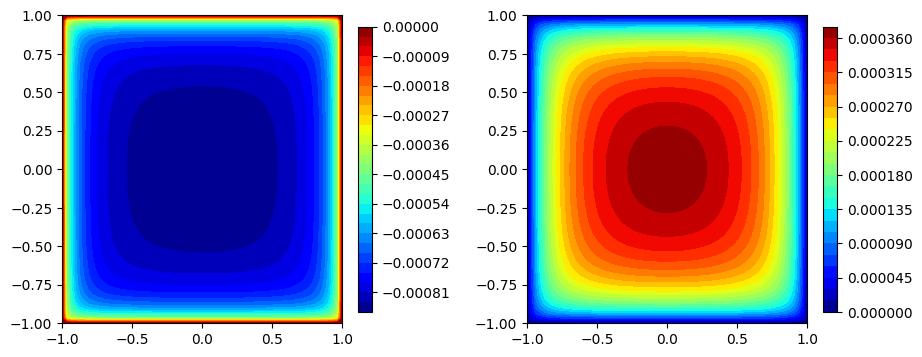

In [27]:
fig1 = plt.figure(figsize=(10,4), dpi=100)
plt.subplots_adjust(wspace=0.5)

plt.subplot(1,2,1)
plt.contourf(X, Y, mean, cmap='jet', levels=32)
plt.colorbar(fraction=0.046)

plt.subplot(1,2,2)
plt.contourf(X, Y, std, cmap='jet', levels=32)
plt.colorbar(fraction=0.046)
plt.show()